In [35]:
# Inspired by martin's implementation: https://github.com/iarata/02456-kan-ntk-project/blob/Phase1Experiments/Experiments/MNISTKANNTK.ipynb
import numpy as np
import pandas as pd
import torch
from torch import nn
import lightning as L
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from lightning.pytorch.loggers import WandbLogger
from introduction_code import GaussianFit, MSELoss_batch
from typing import Union

import sys
sys.path.append('./Convolutional-KANs/kan_convolutional')
from kan import KAN

# Setup Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

# Setup Randomness -- https://lightning.ai/docs/pytorch/stable/common/trainer.html
L.seed_everything(628, workers=True)

# CUDA Efficiency
torch.set_float32_matmul_precision('high')

Seed set to 628


Device: cpu


In [36]:
# Dataset Setup -- Inspired by Hugo's Dataset Reformatting
# Reformatted, due to odd issues when using NTK on it
class LCDataset(Dataset):
    def __init__(self, dataset, num_classes, limit=-1):
        self.limit = limit
        self.num_classes = num_classes
        if self.limit != -1:
            sub = list(np.random.permutation(np.arange(len(dataset)))[0:self.limit]) # Take a random sample of the first some elements.
            self.dataset = Subset(dataset, sub)
        else:
            self.dataset = dataset
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        y_one_hot = torch.zeros(self.num_classes)
        y_one_hot[y] = 1
        return x, y_one_hot

In [37]:
# Split train_dataset into train and validation sets
from torch.utils.data import random_split
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((7,7))
])
train_dataset = MNIST("./temp/", train=True, download=True, transform=transform)
test_dataset = MNIST("./temp/", train=False, download=True, transform=transform)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Add validation dataloader
num_workers = 0
def get_dataloader(split: Union["train", "val", "test", "ntk"]="train", batch_size=64, limit=-1):
    data_loader = None
    if split == "ntk":
        data_loader = DataLoader(
            LCDataset(train_dataset, num_classes=10, limit=500), 
            batch_size=batch_size, num_workers=num_workers
        )
    elif split == "train":
        data_loader = DataLoader(
            LCDataset(train_dataset, num_classes=10, limit=limit), 
            batch_size=batch_size, shuffle=True, num_workers=num_workers
        )
    elif split == "val":
        data_loader = DataLoader(
            LCDataset(val_dataset, num_classes=10, limit=limit), 
            batch_size=batch_size, num_workers=num_workers
        )
    elif split == "test":
        data_loader = DataLoader(
            LCDataset(test_dataset, num_classes=10, limit=500), 
            batch_size=batch_size, num_workers=num_workers
        )
    return data_loader

In [43]:
class ClassicKAN(L.LightningModule):
    def __init__(self, num_hidden_layers=1, hidden_dim=64, inp_size=4*4, out_size=10, grid_size=2, spline_order=2):
        super().__init__()
        self.inp_size = inp_size
        layers_hidden = [inp_size] + [hidden_dim] * num_hidden_layers + [out_size]
        self.net = KAN(width=layers_hidden, grid=grid_size, k=spline_order)
    
    def forward(self, x):
        x = x.view(-1, self.inp_size)
        return self.net(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.mse_loss(y_pred, y)  # MSE Loss works better for NTK
        v1 = torch.argmax(y_pred, dim=1)
        v2 = torch.argmax(y, dim=1)
        accuracy = torch.sum(torch.eq(v1, v2)) / len(y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_accuracy", accuracy, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.mse_loss(y_pred, y)
        v1 = torch.argmax(y_pred, dim=1)
        v2 = torch.argmax(y, dim=1)
        accuracy = torch.sum(torch.eq(v1, v2)) / len(y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_accuracy", accuracy, prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = F.mse_loss(y_pred, y)
        v1 = torch.argmax(y_pred, dim=1)
        v2 = torch.argmax(y, dim=1)
        accuracy = torch.sum(torch.eq(v1, v2)) / len(y)
        self.log("test_loss", loss)
        self.log("test_accuracy", accuracy)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        return self(batch)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

def check_ntk_acc(model, dataloader):
    res = 0.0
    sumlength = 0
    model.eval()
    model.to(device)
    for it in iter(dataloader):
        x, y = it
        x = x.to(device)
        y = y.to(device)
        sumlength += len(x)
        res += (torch.argmax(model.forward(x), dim=1) == torch.argmax(y, dim=1)).sum()
    model.train()
    return res / sumlength

checkpoint directory created: ./model
saving model version 0.0
torch.Size([64, 1, 7, 7])
out


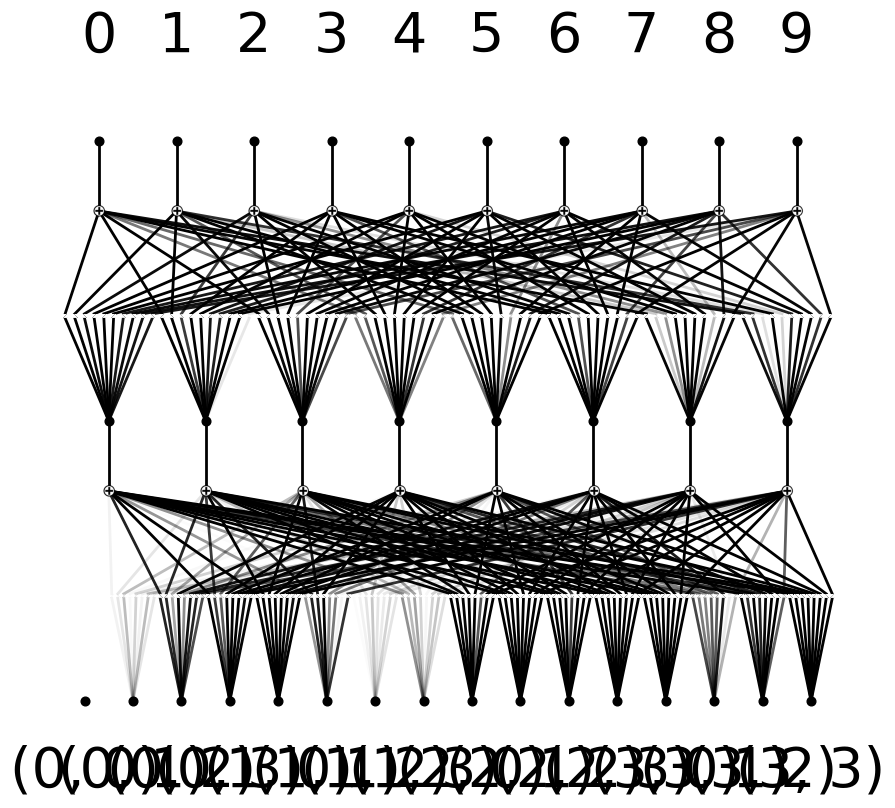

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1)` was configured so validation will run after every batch.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | net  | MultKAN | 2.7 K  | train
-----------------------------------------
2.1 K     Trainable params
656       Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Total parameters: 2736
Trainable parameters: 2080


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\hugom\AppData\Local\Temp\ipykernel_11228\333045766.py:26: UserWarning: Using a target size (torch.Size([64, 10])) that is different to the input size (torch.Size([196, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(y_pred, y)


RuntimeError: The size of tensor a (196) must match the size of tensor b (64) at non-singleton dimension 0

In [44]:
import torch
import lightning as L
from torch.nn import MSELoss
import matplotlib.pyplot as plt
from datetime import datetime
import json
import os

config = {
    'epochs': 1,
    'learning_rate': 0.001,
    'batch_size': 64,
    'num_hidden': 1,
    'hidden_dim': 8,
    'limit': 128,
    'grid_size': 2,
    'spline_order': 2
}

"""Run a single experiment with given configuration."""
# Create output directory
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
output_dir = f"./experiment/experiment_{timestamp}"
os.makedirs(output_dir, exist_ok=True)

# Save configuration
with open(os.path.join(output_dir, 'config.json'), 'w') as f:
    json.dump(config, f, indent=4)

# Load data
train_loader = get_dataloader(split="train", batch_size=config['batch_size'], limit=-1)
val_loader = get_dataloader(split="val", batch_size=config['batch_size'], limit=-1)
test_loader = get_dataloader(split="test", batch_size=config['batch_size'])
ntk_loader = get_dataloader(split="ntk", batch_size=config['batch_size'], limit=config['limit'])

# Initialize model
model = ClassicKAN(
    num_hidden_layers=config['num_hidden'],
    hidden_dim=config['hidden_dim'],
    grid_size=config['grid_size'],
    spline_order=config['spline_order']
).to(device)
model.net.to(device)

for d,t in train_loader:
    print(d.shape)
    model.net(d.view(64, -1))
    break
print("out")
inp = [f"({i}, {j})" for i in range(4) for j in range(4)]
model.net.plot(beta=100, scale=1, in_vars=inp, out_vars=list(range(10)))

plt.show()

# Log model parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

# Custom callback for logging
class MetricsCallback(L.Callback):
    def __init__(self, output_dir):
        super().__init__()
        self.metrics = {'train_loss': [], 'val_loss': []}
        self.output_dir = output_dir
        
    def on_train_epoch_end(self, trainer, pl_module):
        self.metrics['train_loss'].append(trainer.callback_metrics.get('train_loss', 0))
        
    def on_validation_epoch_end(self, trainer, pl_module):
        self.metrics['val_loss'].append(trainer.callback_metrics.get('val_loss', 0))
        
    def on_fit_end(self, trainer, pl_module):
        # Plot training curves
        plt.figure(figsize=(10, 6))
        plt.plot(self.metrics['train_loss'], label='Train Loss')
        plt.plot(self.metrics['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Progress')
        plt.legend()
        plt.savefig(os.path.join(self.output_dir, 'training_curves.png'))
        plt.close()

# Training
metrics_callback = MetricsCallback(output_dir)
trainer = L.Trainer(
    max_epochs=config['epochs'],
    deterministic=True,
    callbacks=[metrics_callback],
    val_check_interval=1,
    enable_progress_bar=True
)

trainer.fit(model, train_loader, val_loader)
test_results = trainer.test(model, test_loader)

# Compute NTK accuracy
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
ntk_model = GaussianFit(model=model, device=device, noise_var=0.0)
ntk_model.fit(ntk_loader, optimizer, MSELoss_batch)
ntk_acc = check_ntk_acc(model, test_loader)
print(f"NTK Accuracy: {ntk_acc.item()}")

# Save example predictions
example_batch = next(iter(test_loader))
example_images, example_labels = example_batch
predictions_KAN = model(example_images.to(device)).argmax(dim=1)
predictions_NTKAN = ntk_model(example_images.to(device)).argmax(dim=1)

# Plot and save example predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(min(10, len(example_images))):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(example_images[i].squeeze(), cmap='gray')
    axes[row, col].set_title(f'KAN: {predictions_KAN[i]}\nNTKAN: {predictions_NTKAN[i]}\nTrue: {example_labels[i]}')
    axes[row, col].axis('off')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'predictions.png'))
plt.close()

# Save results
results = {
    'test_results': test_results,
    'ntk_accuracy': ntk_acc.item(),
    'total_parameters': total_params,
    'trainable_parameters': trainable_params
}
with open(os.path.join(output_dir, 'results.json'), 'w') as f:
    json.dump(results, f, indent=4)